In [1]:
from profiler.core import *

## 0. Load Model

In [2]:
from pgmpy.readwrite import BIFReader
reader = BIFReader("data/earthquake.bif")
model = reader.get_model()
from pgmpy.sampling import BayesianModelSampling
inference = BayesianModelSampling(model)
data = inference.forward_sample(size=100000, return_type='dataframe')

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [3]:
pf = Profiler(workers=2, tol=0, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [4]:
pf.session.load_data(name='hospital', src=DF, df=data, check_param=True)

INFO:profiler.utility:[0.005797863006591797] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': {'', '?', 'unknown', 'None', 'NaN', 'none', 'nan'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "Earthquake": "numeric",
    "Burglary": "numeric",
    "Alarm": "numeric",
    "JohnCalls": "numeric",
    "MaryCalls": "numeric"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'Earthquake': ['equal'], 'Burglary': ['equal'], 'Alarm': ['equal'], 'JohnCalls': ['equal'], 'MaryCalls': ['equal']}
INFO:profiler.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utility:[0.023155927658081055] Load Data execution time: 0.017358064651489258



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [5]:
pf.session.load_training_data(difference=False)

INFO:profiler.utility:[0.0281679630279541] Create Training Data start

INFO:profiler.utility:[0.0330960750579834] Create Training Data execution time: 0.004928112030029297



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [6]:
autoregress_matrix = pf.session.learn_structure(sparsity=0, infer_order=False)

INFO:profiler.utility:[0.03803300857543945] Learn Structure start

INFO:profiler.learner:use threshold 0.0201
INFO:profiler.utility:[0.04490780830383301] Learn Structure execution time: 0.006874799728393555



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [7]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[0.04974079132080078] Get Dependencies start

INFO:profiler.utility:[0.06848382949829102] Get Dependencies execution time: 0.018743038177490234



Earthquake -> Burglary (0.009919490238461195)
Earthquake,Burglary -> Alarm (0.0037174039354189387)
Alarm -> JohnCalls (0.04784606528527187)
Earthquake,Alarm -> MaryCalls (0.014813245142581224)


In [8]:
# create ancester set
model_parents = {}
for node, children in model.edge.items():
    for child in list(children.keys()):
        if child not in model_parents:
            model_parents[child] = []
        model_parents[child].append(node)

In [9]:
# create ancesters
def find_ancesters(node):
    a = []
    if node not in model_parents:
        return a
    for p in model_parents[node]:
        a.append(p)
        a.extend(find_ancesters(p))
    return a

In [10]:
count = 0
tp = 0
for right in parent_sets:
    for parent in parent_sets[right]:
        count += 1
        if parent in find_ancesters(right):
            tp += 1
print("Precision: %.4f"%(tp / float(count)))

Precision: 0.8333


## 5. Visualization

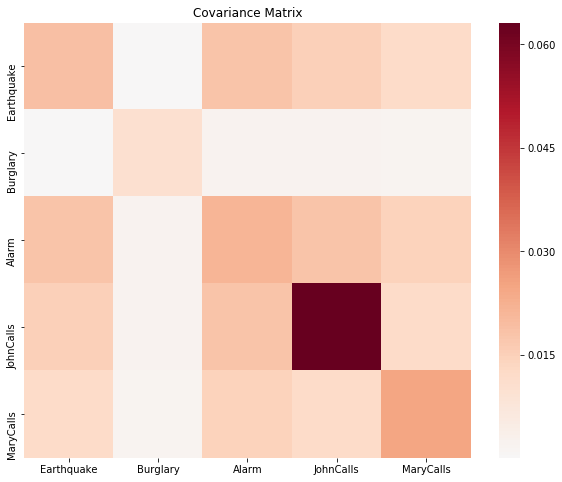

In [15]:
pf.session.visualize_covariance()

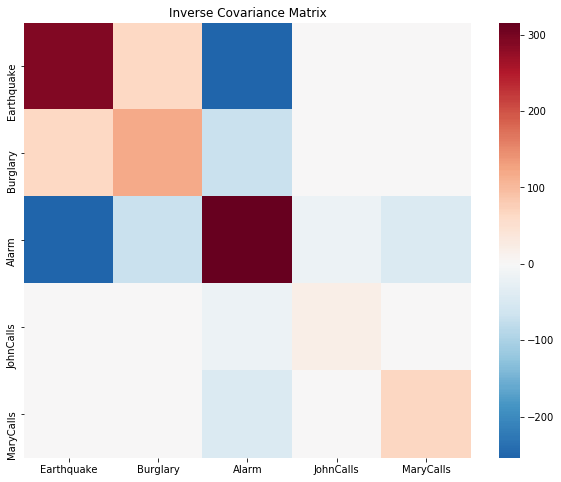

In [12]:
pf.session.visualize_inverse_covariance()

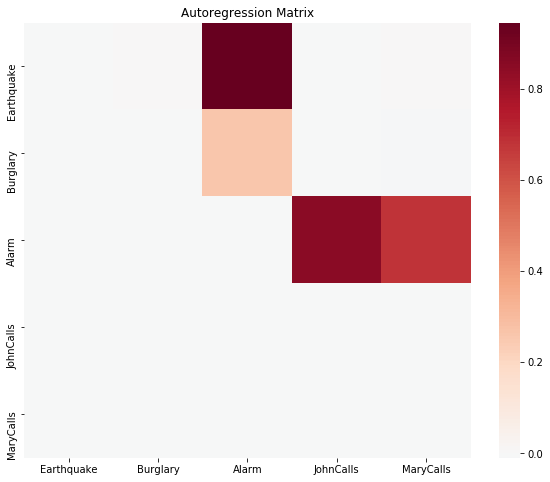

In [13]:
pf.session.visualize_autoregression()

In [14]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.005798,start: Load Data,0.000000
1,0.023156,end: Load Data,0.017358
2,0.028168,start: Create Training Data,0.000000
3,0.033096,end: Create Training Data,0.004928
4,0.038033,start: Learn Structure,0.000000
5,0.044908,end: Learn Structure,0.006875
6,0.049741,start: Get Dependencies,0.000000
7,0.068484,end: Get Dependencies,0.018743
8,0.068484,total_execution_time,0.047904
